## IsolationForest

In [15]:
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [16]:
data = pd.read_csv('./anomaly_dataset.csv')

In [17]:
data

,Velocity,Direction,label
0,0.265570,4.227153,0
1,0.300980,3.628604,0
2,0.171430,2.784595,0
3,0.319400,3.400146,0
4,0.216679,3.591772,0
...,...,...,...
18030,0.231716,2.996458,0
18031,0.118288,3.533865,0
18032,0.160724,3.785585,0
18033,0.130927,3.427468,0


In [18]:
data.loc[data['label'] == 1, 'label'] = -1
data.loc[data['label'] == 0, 'label'] = 1

In [19]:
from sklearn.model_selection import train_test_split

X = data[data.columns].iloc[ : , 0:-1]
y = data['label']

use_cols = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y) 

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(y_train.value_counts(), '\n', y_test.value_counts())

(14428, 2) (3607, 2)
(14428,) (3607,)
 1    13662
-1      766
Name: label, dtype: int64 
  1    3416
-1     191
Name: label, dtype: int64


In [20]:
result_df = data.copy()

model = IsolationForest(n_estimators = 100, 
                               max_samples = len(X_train), 
                               contamination = 0.05)

model.fit(X_train.to_numpy(), y_train)

IsolationForest(contamination=0.05, max_samples=14428)

In [21]:
result_df = pd.concat([X_test, y_test], axis = 1)

y_pred = model.predict(X_test.to_numpy())


In [22]:
# Predict the anomalies
# Change the anomalies' values to make it consistent with the true values
y_pred = [-1 if i==-1 else 1 for i in y_pred]
# Check the model performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.69      0.65      0.67       191
           1       0.98      0.98      0.98      3416

    accuracy                           0.97      3607
   macro avg       0.84      0.82      0.83      3607
weighted avg       0.97      0.97      0.97      3607



In [23]:
result_df['score'] = abs(model.score_samples(X_test.to_numpy()))
result_df['label2'] = result_df['label'].apply(lambda x : 1 if x == -1 else 0)

result_df

,Velocity,Direction,label,score,label2
4711,1.814518,4.874048,-1,0.600285,1
12021,0.161686,4.174105,1,0.401090,0
8278,0.953546,3.546267,1,0.442075,0
16174,0.064283,3.381163,1,0.378575,0
17476,0.367200,4.059291,1,0.414312,0
...,...,...,...,...,...
11031,0.214281,4.284427,1,0.421509,0
9975,0.306656,3.069170,1,0.387593,0
10749,0.244587,3.906912,1,0.402075,0
2390,0.077948,2.089454,1,0.412460,0


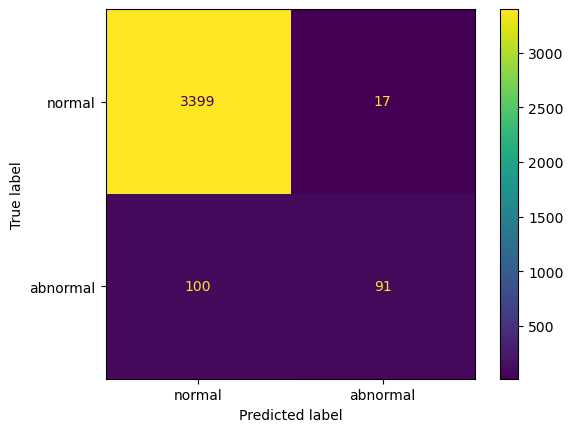

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred = [1 if i >= 0.55 else 0 for i in result_df['score'].values]

label=['normal','abnormal']
cm = confusion_matrix(y_true=result_df['label2'].values, y_pred=pred)
cmd = ConfusionMatrixDisplay(cm,display_labels=label)
cmd.plot()

In [25]:
result_df['score2'] = result_df['score'].apply(lambda x : int(x*100))

In [26]:
df_plot = result_df.groupby(['label2','score2']).size().reset_index().pivot(columns='label2', index='score2', values=0)

<Axes: xlabel='score2'>

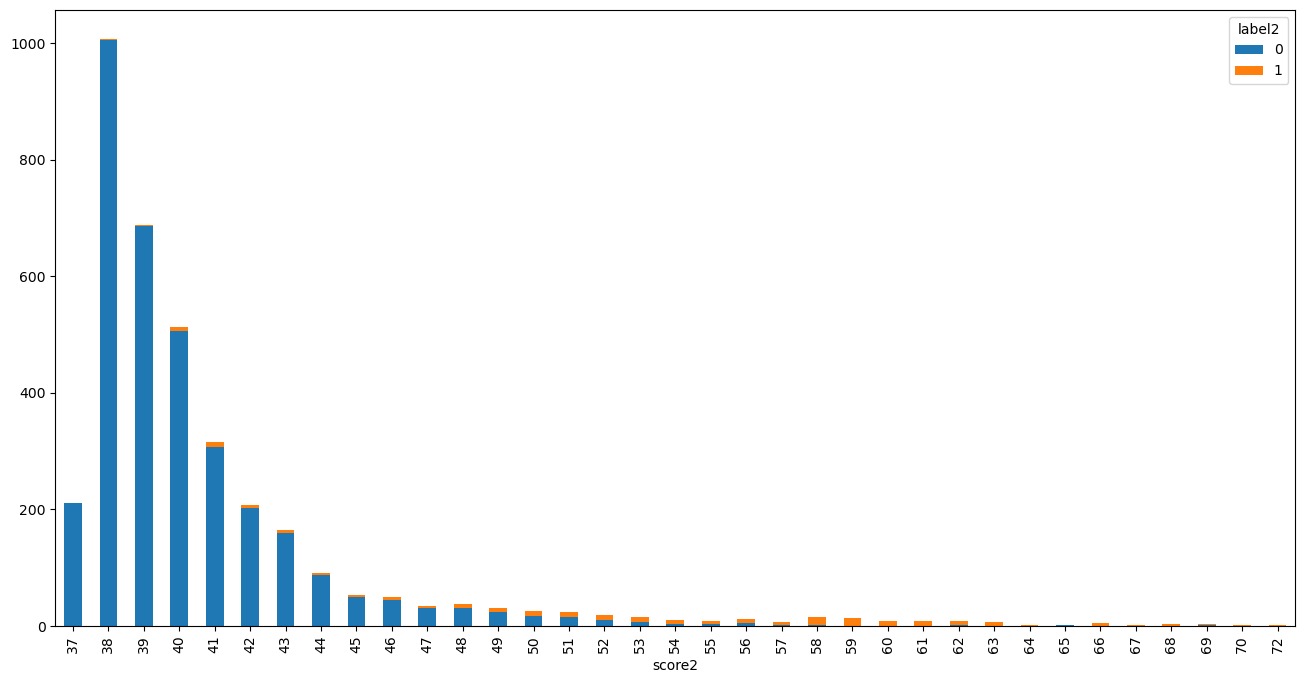

In [27]:
df_plot.plot(kind='bar',stacked=True, figsize=(16,8))